# preparation

In [1]:
import pandas as pd
import numpy as np

#モデル
import lightgbm as lgb

#パラメータ探索
import optuna

#クロスバリデーション
from sklearn.model_selection import KFold

#エヴァリュエーション
from sklearn.metrics import precision_score, recall_score, mean_squared_error

#可視化
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#保存
import pickle

In [2]:
#データを読み込む
j_uma_race_df = pd.read_pickle('../datasets/traindata/j_uma_race.pkl')
j_payout_df = pd.read_pickle('../datasets/traindata/j_payout.pkl')
n_payout_df = pd.read_pickle('../datasets/traindata/n_payout.pkl')

In [3]:
#データを結合する
payout_df = pd.concat([j_payout_df, n_payout_df], axis=0).reset_index(drop=True)

### データの削除

In [4]:
#海外のレースを削除
j_uma_race_df['keibajo_code'] = pd.to_numeric(j_uma_race_df['keibajo_code'], errors='coerce')
j_uma_race_df = j_uma_race_df.dropna(subset=['keibajo_code'])
j_uma_race_df['keibajo_code']  = j_uma_race_df['keibajo_code'] .astype(int)

#レースに参加できていない競走馬を削除
j_uma_race_df= j_uma_race_df[j_uma_race_df['kakutei_chakujun'] != 0]

# LightGBM

## グループクエリ用のカラムを作成

In [5]:
# 新しいグループを作成
j_uma_race_df['group'] = j_uma_race_df['kaisai_nen'].astype(str) +"-"+ j_uma_race_df['kaisai_tsukihi'].astype(str) +"-"+  j_uma_race_df['keibajo_code'].astype(str) +"-"+  j_uma_race_df['race_bango'].astype(str)
payout_df['group'] = payout_df['kaisai_nen'].astype(str) +"-"+ payout_df['kaisai_tsukihi'].astype(str) +"-"+  payout_df['keibajo_code'].astype(str) +"-"+  payout_df['race_bango'].astype(str)

## LightGBM

### テスト用と学習用のデータに分け、モデルを作成

In [6]:
# 2010年から2019年のデータを学習データとして取得
train_data = j_uma_race_df[j_uma_race_df['kaisai_nen'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

# ランキング学習のために必要な特徴量とターゲットを設定
features = [
            'kaisai_nen',
            'kaisai_tsukihi',
            'keibajo_code',
            # 'kaisai_kai',
            # 'kaisai_nichime',
            'race_bango',
            'wakuban',
            'umaban',
            'ketto_toroku_bango',
            # 'bamei',
            'umakigo_code',
            'seibetsu_code',
            'hinshu_code',
            'moshoku_code',
            'barei',
            'tozai_shozoku_code',
            'chokyoshi_code',
            'banushi_code',
            # 'banushimei',
            'futan_juryo',
            'blinker_shiyo_kubun',
            'kishu_code',
            # 'kishumei_ryakusho',
            'kishu_minarai_code',
            'bataiju',
            'zogen_fugo',
            'zogen_sa',
            'ijo_kubun_code',
            # 'nyusen_juni',
            ## 'kakutei_chakujun',
            # 'dochaku_kubun',
            # 'dochaku_tosu',
            # 'soha_time',
            # 'chakusa_code_1',
            # 'chakusa_code_2',
            # 'chakusa_code_3',
            # 'corner_1',
            # 'corner_2',
            # 'corner_3',
            # 'corner_4',
            # 'tansho_odds',
            # 'tansho_ninkijun',
            # 'kakutoku_honshokin',
            # 'kakutoku_fukashokin',
            # 'kohan_4f',
            # 'kohan_3f',
            # 'aiteuma_joho_1',
            # 'aiteuma_joho_2',
            # 'aiteuma_joho_3',
            # 'time_sa',
            # 'record_koshin_kubun',
            # 'kyakushitsu_hantei',
            ]


target = 'kakutei_chakujun'

# LightGBM用のデータセットを作成
train_dataset = lgb.Dataset(train_data[features], label=train_data[target])

# LightGBMのパラメータを設定
params = {
    'objective': 'regression',
    'metric': 'rmse', 
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# k=5のFOLDでデータを分割
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 各FOLDでのモデルを保存するためのリスト
models = []

# LightGBMモデルを訓練
for train_index, valid_index in kf.split(train_data):
    train_fold_data = train_data.iloc[train_index]
    valid_fold_data = train_data.iloc[valid_index]
    
    train_dataset = lgb.Dataset(train_fold_data[features], label=train_fold_data[target])
    valid_dataset = lgb.Dataset(valid_fold_data[features], label=valid_fold_data[target])
    
    model = lgb.train(params, train_dataset, num_boost_round=1000, valid_sets=[valid_dataset], early_stopping_rounds=100, verbose_eval=100)
    models.append(model)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number of data points in the train set: 635508, number of used features: 23
[LightGBM] [Info] Start training from score 7.055376
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.76963
[200]	valid_0's rmse: 3.72757
[300]	valid_0's rmse: 3.71181
[400]	valid_0's rmse: 3.70358
[500]	valid_0's rmse: 3.69737
[600]	valid_0's rmse: 3.69226
[700]	valid_0's rmse: 3.68778
[800]	valid_0's rmse: 3.68407
[900]	valid_0's rmse: 3.6814
[1000]	valid_0's rmse: 3.67852
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.67852
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024833 seconds.
You can set `force_row_wise=true` to remov

### テストデータで予測

In [7]:
# 2020年から2022年のテストデータを取得
test_data_2020 = j_uma_race_df[j_uma_race_df['kaisai_nen'] == 2020].copy()
test_data_2021 = j_uma_race_df[j_uma_race_df['kaisai_nen'] == 2021].copy()
test_data_2022 = j_uma_race_df[j_uma_race_df['kaisai_nen'] == 2022].copy()

# 2021年と2022年のデータに対して予測を行い、平均を取る
test_data_2020.loc[:, 'y_pred'] = sum([model.predict(test_data_2020[features], num_iteration=model.best_iteration) for model in models]) / len(models)
test_data_2021.loc[:, 'y_pred'] = sum([model.predict(test_data_2021[features], num_iteration=model.best_iteration) for model in models]) / len(models)
test_data_2022.loc[:, 'y_pred'] = sum([model.predict(test_data_2022[features], num_iteration=model.best_iteration) for model in models]) / len(models)

# 予測されたランクをグループごとに計算
test_data_2020.loc[:, 'predicted_rank'] = test_data_2020.groupby('group')['y_pred'].rank(method='min')
test_data_2021.loc[:, 'predicted_rank'] = test_data_2021.groupby('group')['y_pred'].rank(method='min')
test_data_2022.loc[:, 'predicted_rank'] = test_data_2022.groupby('group')['y_pred'].rank(method='min')

# 結果を表示
test_data_2021[['group', 'predicted_rank', 'kakutei_chakujun']]

,group,predicted_rank,kakutei_chakujun
883724,2021-101-45-10,1.0,3
883725,2021-101-45-10,6.0,6
883726,2021-101-45-10,5.0,5
883727,2021-101-45-10,3.0,4
883728,2021-101-45-10,2.0,1
...,...,...,...
1070762,2021-923-42-11,2.0,1
1070772,2021-1203-43-11,4.0,3
1070776,2021-1020-42-11,1.0,9
1070784,2021-908-44-11,2.0,10


## モデル評価

### RMSE

In [8]:
# RMSEを計算
rmse_2020 = np.sqrt(mean_squared_error(test_data_2020['predicted_rank'], test_data_2020['kakutei_chakujun']))
print(f"2021 RMSE: {rmse_2020:.3%}")
rmse_2021 = np.sqrt(mean_squared_error(test_data_2021['predicted_rank'], test_data_2021['kakutei_chakujun']))
print(f"2021 RMSE: {rmse_2021:.3%}")
rmse_2022 = np.sqrt(mean_squared_error(test_data_2022['predicted_rank'], test_data_2022['kakutei_chakujun']))
print(f"2022 RMSE: {rmse_2022:.3%}")
rmse_mean = np.mean([rmse_2020, rmse_2021, rmse_2022])
print(f"Mean RMSE: {rmse_mean:.3%}")

2021 RMSE: 459.016%
2021 RMSE: 466.947%
2022 RMSE: 462.745%
Mean RMSE: 462.903%


### precision@5&recall@5

In [9]:
#precision@5とrecall@5を計算
def precision_at_5(predictions, actual):
    top_5_predictions = predictions.argsort()[-5:][::-1]  # 予測の上位5頭のインデックス
    top_3_actual = actual.argsort()[-3:][::-1]  # 実際の上位3頭のインデックス
    common_elements = np.intersect1d(top_5_predictions, top_3_actual)  # 共通の要素を抽出
    precision = len(common_elements) / 5
    return precision

def recall_at_5(predictions, actual):
    top_5_predictions = predictions.argsort()[-5:][::-1]  # 予測の上位5頭のインデックス
    top_3_actual = actual.argsort()[-3:][::-1]  # 実際の上位3頭のインデックス
    common_elements = np.intersect1d(top_5_predictions, top_3_actual)  # 共通の要素を抽出
    recall = len(common_elements) / 3
    return recall

In [10]:
group_ids_2020 = test_data_2020['group'].unique()
precisions = []
recalls = []

#各レースごとでPrecision@5とRecall@5を計算
for group_id in group_ids_2020:
    test_data = test_data_2020[test_data_2020['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2020 = np.mean(precisions)
recall_5_2020 = np.mean(recalls)

print(f"2020 Precision@5: {precision_5_2020:.3%}")
print(f"2020 Recall@5: {recall_5_2020:.3%}")


group_ids_2021 = test_data_2021['group'].unique()
precisions = []
recalls = []

#各レースごとでPrecision@5とRecall@5を計算
for group_id in group_ids_2021:
    test_data = test_data_2021[test_data_2021['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2021 = np.mean(precisions)
recall_5_2021 = np.mean(recalls)

print(f"2021 Precision@5: {precision_5_2021:.3%}")
print(f"2021 Recall@5: {recall_5_2021:.3%}")


roup_ids_2022 = test_data_2022['group'].unique()
precisions = []
recalls = []

for group_id in roup_ids_2022:
    test_data = test_data_2022[test_data_2022['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2022 = np.mean(precisions)
recall_5_2022 = np.mean(recalls)

print(f"2022 Precision@5: {precision_5_2022:.3%}")
print(f"2022 Recall@5: {recall_5_2022:.3%}")


precision_5_mean = np.mean([precision_5_2020, precision_5_2021, precision_5_2022])
recall_5_mean = np.mean([recall_5_2020, recall_5_2021, recall_5_2022])

print(f"Mean Precision@5: {precision_5_mean:.3%}")
print(f"Mean Recall@5: {recall_5_mean:.3%}")

2020 Precision@5: 34.117%
2020 Recall@5: 56.861%
2021 Precision@5: 33.100%
2021 Recall@5: 55.167%
2022 Precision@5: 33.729%
2022 Recall@5: 56.214%
Mean Precision@5: 33.648%
Mean Recall@5: 56.081%


### 収支(三連複五頭ボックス)

In [11]:
# 各レースごとに予測ランキング上位5頭のうち、実際の上位3頭がすべて入っているかを確認する関数
def check_top3_in_top5_predictions(group):
    predicted_top5 = group.nsmallest(5, 'y_pred').index.tolist()
    actual_top3 = group.nsmallest(3, 'kakutei_chakujun').index.tolist()
    return all([horse in predicted_top5 for horse in actual_top3])

In [13]:
# 各レースで上記の関数を適用
results_2020 = test_data_2020.groupby('group').apply(check_top3_in_top5_predictions)
results_2021 = test_data_2021.groupby('group').apply(check_top3_in_top5_predictions)
results_2022 = test_data_2022.groupby('group').apply(check_top3_in_top5_predictions)

# 予測モデルが成功したレースのインデックスを取得する
successful_groups_2020 = results_2020[results_2020].index
successful_groups_2021 = results_2021[results_2021].index
successful_groups_2022 = results_2022[results_2022].index

# そのインデックスを使用して、harai_dfから対応する支払倍率を取得する
successful_payout_2020 = payout_df[payout_df['group'].isin(successful_groups_2020)]
successful_payout_2021 = payout_df[payout_df['group'].isin(successful_groups_2021)]
successful_payout_2022 = payout_df[payout_df['group'].isin(successful_groups_2022)]

payouts_2020 = successful_payout_2020['haraimodoshi_sanrenpuku_1b']
payouts_2021 = successful_payout_2021['haraimodoshi_sanrenpuku_1b']
payouts_2022 = successful_payout_2022['haraimodoshi_sanrenpuku_1b']

# すべての成功したレースに対して、100円をかけた場合の支払いを計算する
total_payout_2020 = (payouts_2020).sum()
total_payout_2021 = (payouts_2021).sum()
total_payout_2022 = (payouts_2022).sum()

# 合計の支払いから、すべてのレースにかけた合計金額を引くことで、純利益を計算する
total_investment_2020 = test_data_2020['group'].nunique() * 1000
total_investment_2021 = test_data_2021['group'].nunique() * 1000
total_investment_2022 = test_data_2021['group'].nunique() * 1000

net_profit_2020 = total_payout_2020 - total_investment_2020
net_profit_2021 = total_payout_2021 - total_investment_2021
net_profit_2022 = total_payout_2022 - total_investment_2022

average_net_profit_2020 = net_profit_2020/len(test_data_2020)
average_net_profit_2021 = net_profit_2021/len(test_data_2021)
average_net_profit_2022 = net_profit_2020/len(test_data_2022)

print(f"2020 Average Net Profit: {average_net_profit_2020:.3f} yen")
print(f"2021 Average Net Profit: {average_net_profit_2021:.3f} yen")
print(f"2022 Average Net Profit: {average_net_profit_2022:.3f} yen")

mean_average_net_profit = np.mean([average_net_profit_2020, average_net_profit_2021, average_net_profit_2022])
print(f"Mean Average Net Profit: {mean_average_net_profit:.3f} yen")

2020 Average Net Profit: -24.454 yen
2021 Average Net Profit: -29.243 yen
2022 Average Net Profit: -24.903 yen
Mean Average Net Profit: -26.200 yen


In [14]:
# 1. 各レースごとに予測ランキング上位5頭のうち、実際の上位3頭がすべて入っているかを確認する関数
def check_top3_in_top5_predictions(group):
    predicted_top5 = group.nsmallest(5, 'y_pred').index.tolist()
    actual_top3 = group.nsmallest(3, 'kakutei_chakujun').index.tolist()
    return all([horse in predicted_top5 for horse in actual_top3])

# 2. 各グループの利益を計算する関数
def calculate_group_profit(group):
    if check_top3_in_top5_predictions(group):
        payout_value = group['haraimodoshi_sanrenpuku_1b'].iloc[0]
        return payout_value - 1000
    else:
        return -1000

# 3. 各テストデータに対して利益を計算し、新しいカラムとして追加
for test_data in [test_data_2020, test_data_2021, test_data_2022]:
    # test_dataとpayout_dfをマージ
    merged_data = pd.merge(test_data, payout_df[['group', 'haraimodoshi_sanrenpuku_1b']], on='group', how='left')
    profits = merged_data.groupby('group').apply(calculate_group_profit).reset_index()
    profits.columns = ['group', 'profit']
    test_data = pd.merge(test_data, profits, on='group', how='left')

### 予測を見る

In [15]:
# # ```
# # すべての予測を見たい時用（処理時間かかる）
# # ```

# #グループごとの予測値と実際値を見てみる
# for group_id in group_ids_2021:
#     test_data = test_data_2021[test_data_2021['group'] == group_id]
#     sorted_test_data = test_data.sort_values(by='kakutei_chakujun')
#     print(sorted_test_data[['group', 'predicted_rank', 'kakutei_chakujun']])

# モデル保存

In [16]:
# モデルを保存
with open('bestmodels/benchmark.pkl', 'wb') as f:
    pickle.dump(models, f)

# 分析

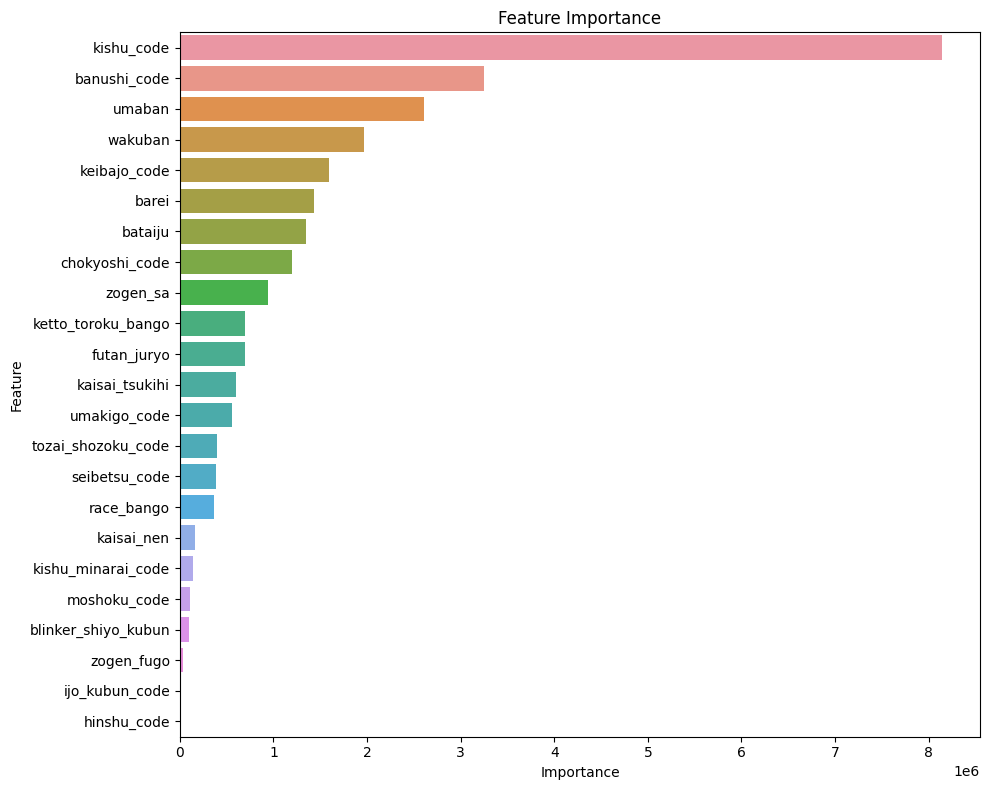

In [17]:
# models[0]の特徴量の重要度を取得
feature_importance = models[0].feature_importance(importance_type='gain')

# 特徴量の名前と重要度をDataFrameに変換
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# 重要度の降順にソート
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# プロット
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

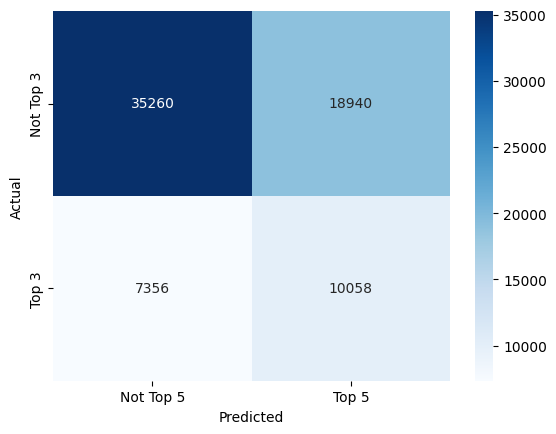

In [18]:
# 予測ランキングの上位5頭を1、それ以外を0とする
test_data_2021.loc[:, 'predicted_top5'] = test_data_2021.groupby('group')['y_pred'].rank(ascending=True).apply(lambda x: 1 if x <= 5 else 0)

# 実際のランキングの上位3頭を1、それ以外を0とする
test_data_2021.loc[:, 'actual_top3'] = test_data_2021['kakutei_chakujun'].apply(lambda x: 1 if x <= 3 else 0)

# Confusion Matrixを計算
cm = confusion_matrix(test_data_2021['actual_top3'], test_data_2021['predicted_top5'])

# Confusion Matrixを表示
x_label = ['Not Top 5', 'Top 5']
y_label = ['Not Top 3', 'Top 3']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=x_label, yticklabels=y_label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
#正解したレースの特徴を調べる

In [20]:
successful_groups = test_data_2021.groupby('group').apply(check_top3_in_top5_predictions)
successful_races = test_data_2021[test_data_2021['group'].isin(successful_groups[successful_groups].index)]

In [21]:
successful_races

,kaisai_nen,kaisai_tsukihi,keibajo_code,kaisai_kai,kaisai_nichime,race_bango,wakuban,umaban,ketto_toroku_bango,bamei,...,aiteuma_joho_2,aiteuma_joho_3,time_sa,record_koshin_kubun,kyakushitsu_hantei,group,y_pred,predicted_rank,predicted_top5,actual_top3
883724,2021,101,45,12,1,10,1,1,2016105658,アイオロス,...,0000000000,0000000000,7,0,1,2021-101-45-10,5.693937,1.0,1,1
883725,2021,101,45,12,1,10,2,2,2017100660,ポピュラーソング,...,0000000000,0000000000,35,0,4,2021-101-45-10,7.043861,6.0,0,0
883726,2021,101,45,12,1,10,3,3,2013101325,モンスターキング,...,0000000000,0000000000,26,0,2,2021-101-45-10,6.909014,5.0,1,0
883727,2021,101,45,12,1,10,4,4,2016100496,アルネゴー,...,0000000000,0000000000,21,0,4,2021-101-45-10,5.954438,3.0,1,0
883728,2021,101,45,12,1,10,5,5,2015101657,シカゴジャズ,...,0000000000,0000000000,-4,0,1,2021-101-45-10,5.838475,2.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070660,2021,1203,43,9,5,11,1,1,2015103221,ヒラボクラターシュ,...,0000000000,0000000000,26,0,3,2021-1203-43-11,5.260325,2.0,1,0
1070664,2021,812,43,5,4,11,5,5,2015105072,マグナレガーロ,...,0000000000,0000000000,-12,0,2,2021-812-43-11,6.250506,2.0,1,1
1070716,2021,1203,43,9,5,11,8,8,2016106450,タイサイ,...,0000000000,0000000000,-1,0,2,2021-1203-43-11,5.577732,3.0,1,1
1070745,2021,1203,43,9,5,11,6,6,2017102172,ブラヴール,...,0000000000,0000000000,1,0,3,2021-1203-43-11,5.108405,1.0,1,1


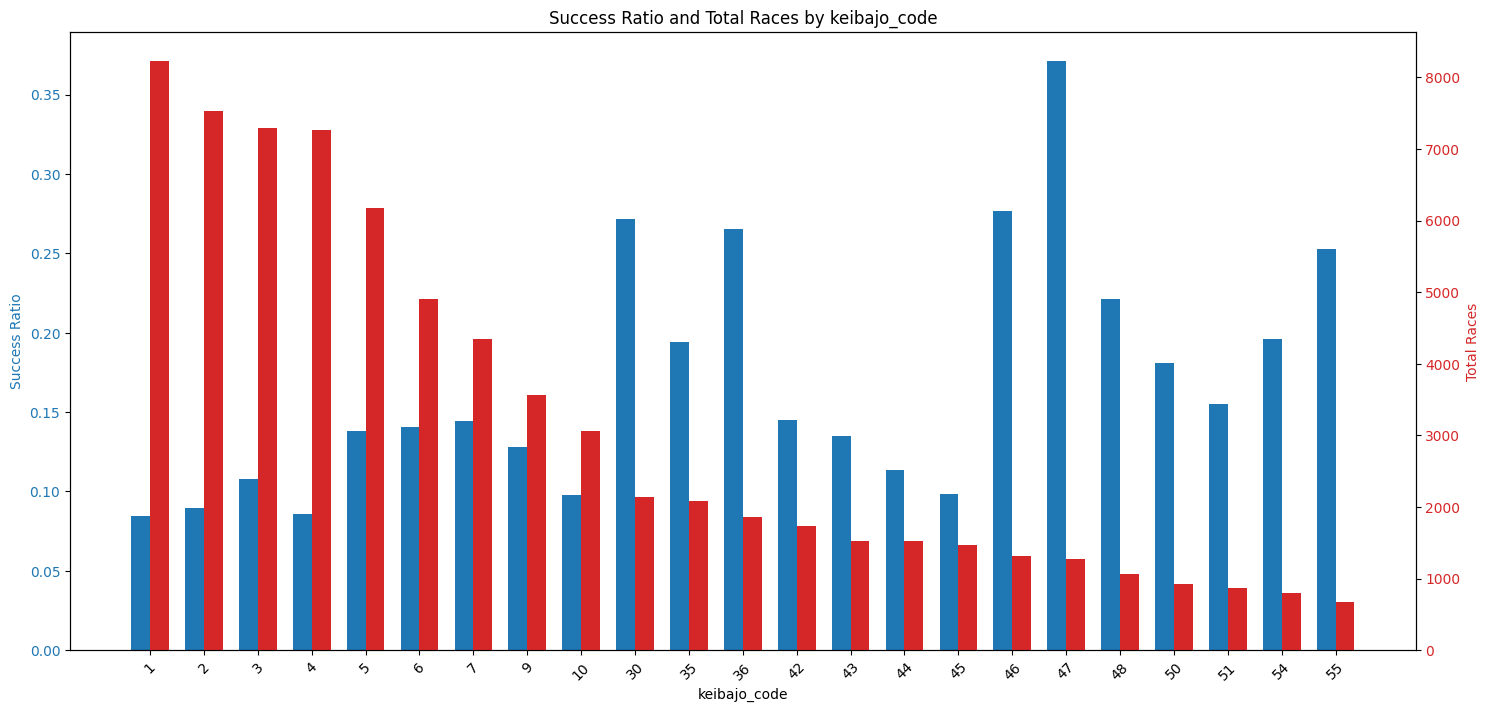

In [22]:
# 全体のJyoCDの分布を取得
total_counts = test_data_2021['keibajo_code'].value_counts()

# successful_racesの中のJyoCDの分布を取得
success_counts = successful_races['keibajo_code'].value_counts()

# 正解したレースの割合を計算
success_ratio = success_counts / total_counts

# データを双方向の棒グラフで可視化
labels = success_ratio.index
x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:blue'
ax1.set_xlabel('keibajo_code')
ax1.set_ylabel('Success Ratio', color=color)
ax1.bar(x - width/2, success_ratio, width, color=color, label='Success Ratio')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Races', color=color)
ax2.bar(x + width/2, total_counts, width, color=color, label='Total Races')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Success Ratio and Total Races by keibajo_code')
plt.show()

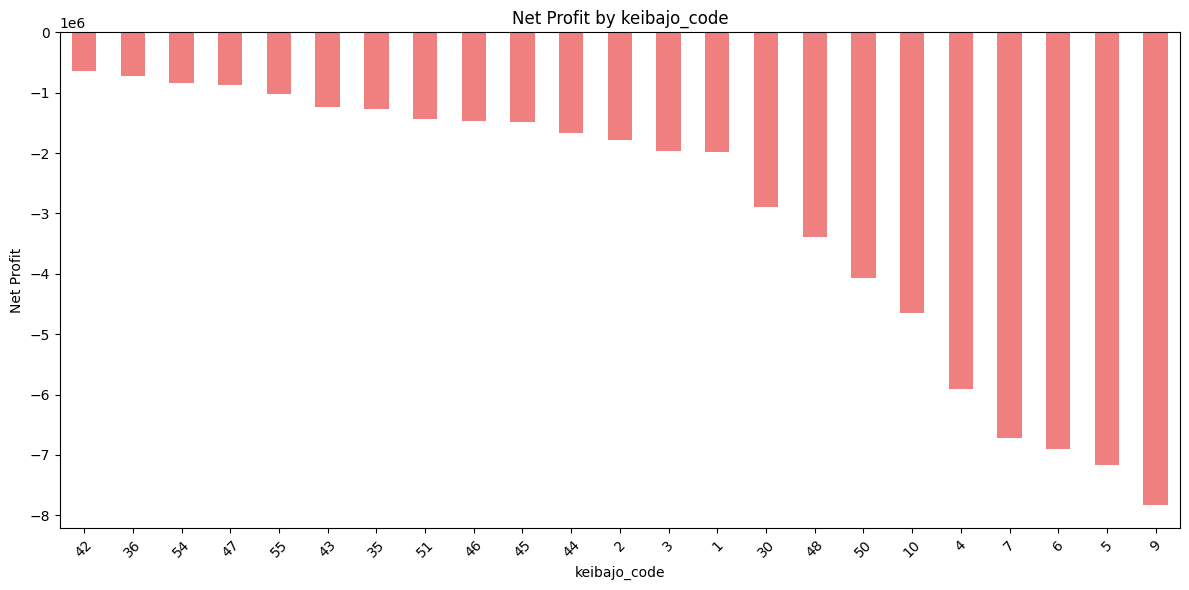

In [23]:
# 各競馬場での成功したレースの支払いを合計
total_payouts = successful_payout_2021.groupby('keibajo_code')['haraimodoshi_sanrenpuku_1b'].sum()

# 各競馬場での投資額を計算
total_investments = test_data_2021['keibajo_code'].value_counts() * 1000

# 各競馬場での純利益を計算
net_profits = total_payouts - total_investments 

# データを棒グラフで可視化
net_profits.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), color='lightcoral')
plt.title('Net Profit by keibajo_code')
plt.xlabel('keibajo_code')
plt.ylabel('Net Profit')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
total_payouts

keibajo_code
1     158810.0
2      76450.0
3     128260.0
4     270710.0
5     372070.0
6     383370.0
7     547950.0
9     400160.0
10    257960.0
30    163280.0
35     49580.0
36     67900.0
42     44130.0
43     23690.0
44     54640.0
45     48460.0
46     59640.0
47     51040.0
48    171040.0
50    275670.0
51     41100.0
54     25670.0
55     34230.0
Name: haraimodoshi_sanrenpuku_1b, dtype: float64

In [25]:
total_investments

keibajo_code
9     8223000
5     7534000
6     7290000
7     7260000
4     6182000
10    4909000
50    4349000
48    3562000
30    3056000
1     2133000
3     2086000
2     1859000
44    1728000
46    1531000
45    1527000
51    1475000
35    1314000
43    1268000
55    1059000
47     922000
54     871000
36     799000
42     677000
Name: count, dtype: int64

In [26]:
net_profits

keibajo_code
1    -1974190.0
2    -1782550.0
3    -1957740.0
4    -5911290.0
5    -7161930.0
6    -6906630.0
7    -6712050.0
9    -7822840.0
10   -4651040.0
30   -2892720.0
35   -1264420.0
36    -731100.0
42    -632870.0
43   -1244310.0
44   -1673360.0
45   -1478540.0
46   -1471360.0
47    -870960.0
48   -3390960.0
50   -4073330.0
51   -1433900.0
54    -845330.0
55   -1024770.0
dtype: float64

In [ ]:
def objective(trial):
    # Optunaで調整するパラメータを設定
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
    }
    
    # k=5のFOLDでデータを分割
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # 各FOLDでの評価値を保存するためのリスト
    rmses = []
    
    # LightGBMモデルを訓練
    for train_index, valid_index in kf.split(train_data):
        train_fold_data = train_data.iloc[train_index]
        valid_fold_data = train_data.iloc[valid_index]
        
        train_dataset = lgb.Dataset(train_fold_data[features], label=train_fold_data[target])
        valid_dataset = lgb.Dataset(valid_fold_data[features], label=valid_fold_data[target])
        
        model = lgb.train(params, train_dataset, num_boost_round=1000, valid_sets=[valid_dataset], early_stopping_rounds=100, verbose_eval=100)
        
        # RMSEを計算して保存
        y_pred = model.predict(valid_fold_data[features])
        rmse = np.sqrt(mean_squared_error(valid_fold_data[target], y_pred))
        rmses.append(rmse)
    
    # 5-FOLDの平均RMSEを返す
    return np.mean(rmses)

# Optunaでのパラメータ探索を実行
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# 最適なパラメータ
best_params = study.best_params
best_params['metric'] = 'rmse'  # ここでmetricを追加

# KFoldでのモデル訓練
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = []

for train_index, valid_index in kf.split(train_data):
    train_fold_data = train_data.iloc[train_index]
    valid_fold_data = train_data.iloc[valid_index]
    
    train_dataset = lgb.Dataset(train_fold_data[features], label=train_fold_data[target])
    valid_dataset = lgb.Dataset(valid_fold_data[features], label=valid_fold_data[target])
    
    model = lgb.train(best_params, train_dataset, num_boost_round=500, valid_sets=[valid_dataset], early_stopping_rounds=20, verbose_eval=100)  # ここでearly_stopping_roundsを50に変更
    models.append(model)

[I 2023-10-05 17:14:06,625] A new study created in memory with name: no-name-30b92470-9335-4322-b39f-8116ca851456


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number of data points in the train set: 635508, number of used features: 23
[LightGBM] [Info] Start training from score 7.055376
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.85639
[200]	valid_0's rmse: 3.81193
[300]	valid_0's rmse: 3.78738
[400]	valid_0's rmse: 3.77276
[500]	valid_0's rmse: 3.76028
[600]	valid_0's rmse: 3.75218
[700]	valid_0's rmse: 3.74516
[800]	valid_0's rmse: 3.73903
[900]	valid_0's rmse: 3.73432
[1000]	valid_0's rmse: 3.72991
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.72991
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021932 seconds.
You can set `force_row_wise=true` to remo

[I 2023-10-05 17:16:09,847] Trial 0 finished with value: 3.7314128375227327 and parameters: {'num_leaves': 7, 'learning_rate': 0.04968176540352832, 'feature_fraction': 0.5789352025299188}. Best is trial 0 with value: 3.7314128375227327.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number of data points in the train set: 635508, number of used features: 23
[LightGBM] [Info] Start training from score 7.055376
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 4.08581
[200]	valid_0's rmse: 4.03347
[300]	valid_0's rmse: 3.99257
[400]	valid_0's rmse: 3.95899
[500]	valid_0's rmse: 3.93199
[600]	valid_0's rmse: 3.90999
[700]	valid_0's rmse: 3.89072
[800]	valid_0's rmse: 3.87463
[900]	valid_0's rmse: 3.86059
[1000]	valid_0's rmse: 3.84823
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.84823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028241 seconds.
You can set `force_row_wise=true` to remo

[I 2023-10-05 17:20:22,132] Trial 1 finished with value: 3.8474783549264777 and parameters: {'num_leaves': 61, 'learning_rate': 0.0017404239233040882, 'feature_fraction': 0.42920919672619107}. Best is trial 0 with value: 3.7314128375227327.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number of data points in the train set: 635508, number of used features: 23
[LightGBM] [Info] Start training from score 7.055376
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 4.10686
[200]	valid_0's rmse: 4.0696
[300]	valid_0's rmse: 4.03819
[400]	valid_0's rmse: 4.01145
[500]	valid_0's rmse: 3.98871
[600]	valid_0's rmse: 3.96932
[700]	valid_0's rmse: 3.95206
[800]	valid_0's rmse: 3.9371
[900]	valid_0's rmse: 3.92413
[1000]	valid_0's rmse: 3.91207
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.91207
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030583 seconds.
You can set `force_row_wise=true` to remove

[I 2023-10-05 17:24:41,457] Trial 2 finished with value: 3.9113972759922007 and parameters: {'num_leaves': 27, 'learning_rate': 0.0012097939027851947, 'feature_fraction': 0.4711453903011828}. Best is trial 0 with value: 3.7314128375227327.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number of data points in the train set: 635508, number of used features: 23
[LightGBM] [Info] Start training from score 7.055376
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.79617
[200]	valid_0's rmse: 3.73321
[300]	valid_0's rmse: 3.70899
[400]	valid_0's rmse: 3.69143
[500]	valid_0's rmse: 3.68134
[600]	valid_0's rmse: 3.67515
[700]	valid_0's rmse: 3.67061
[800]	valid_0's rmse: 3.66661
[900]	valid_0's rmse: 3.66345
[1000]	valid_0's rmse: 3.65995
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.65995
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036506 seconds.
You can set `force_row_wise=true` to remo

In [ ]:
# 2020年から2022年のテストデータを取得
test_data_2020 = uma_race_df[uma_race_df['kaisai_nen'] == 2020].copy()
test_data_2021 = uma_race_df[uma_race_df['kaisai_nen'] == 2021].copy()
test_data_2022 = uma_race_df[uma_race_df['kaisai_nen'] == 2022].copy()

# 2021年と2022年のデータに対して予測を行い、平均を取る
test_data_2020.loc[:, 'y_pred'] = sum([model.predict(test_data_2020[features], num_iteration=model.best_iteration) for model in models]) / len(models)
test_data_2021.loc[:, 'y_pred'] = sum([model.predict(test_data_2021[features], num_iteration=model.best_iteration) for model in models]) / len(models)
test_data_2022.loc[:, 'y_pred'] = sum([model.predict(test_data_2022[features], num_iteration=model.best_iteration) for model in models]) / len(models)

# 予測されたランクをグループごとに計算
test_data_2020.loc[:, 'predicted_rank'] = test_data_2020.groupby('group')['y_pred'].rank(method='min')
test_data_2021.loc[:, 'predicted_rank'] = test_data_2021.groupby('group')['y_pred'].rank(method='min')
test_data_2022.loc[:, 'predicted_rank'] = test_data_2022.groupby('group')['y_pred'].rank(method='min')

# 結果を表示
test_data_2021[['group', 'predicted_rank', 'kakutei_chakujun']]

In [ ]:
# RMSEを計算
rmse_2020 = np.sqrt(mean_squared_error(test_data_2020['predicted_rank'], test_data_2020['kakutei_chakujun']))
print(f"2021 RMSE: {rmse_2020:.3%}")
rmse_2021 = np.sqrt(mean_squared_error(test_data_2021['predicted_rank'], test_data_2021['kakutei_chakujun']))
print(f"2021 RMSE: {rmse_2021:.3%}")
rmse_2022 = np.sqrt(mean_squared_error(test_data_2022['predicted_rank'], test_data_2022['kakutei_chakujun']))
print(f"2022 RMSE: {rmse_2022:.3%}")
rmse_mean = np.mean([rmse_2020, rmse_2021, rmse_2022])
print(f"Mean RMSE: {rmse_mean:.3%}")

group_ids_2020 = test_data_2020['group'].unique()
precisions = []
recalls = []

#各レースごとでPrecision@5とRecall@5を計算
for group_id in group_ids_2020:
    test_data = test_data_2020[test_data_2020['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2020 = np.mean(precisions)
recall_5_2020 = np.mean(recalls)

print(f"2020 Precision@5: {precision_5_2020:.3%}")
print(f"2020 Recall@5: {recall_5_2020:.3%}")


group_ids_2021 = test_data_2021['group'].unique()
precisions = []
recalls = []

#各レースごとでPrecision@5とRecall@5を計算
for group_id in group_ids_2021:
    test_data = test_data_2021[test_data_2021['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2021 = np.mean(precisions)
recall_5_2021 = np.mean(recalls)

print(f"2021 Precision@5: {precision_5_2021:.3%}")
print(f"2021 Recall@5: {recall_5_2021:.3%}")


roup_ids_2022 = test_data_2022['group'].unique()
precisions = []
recalls = []

for group_id in roup_ids_2022:
    test_data = test_data_2022[test_data_2022['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2022 = np.mean(precisions)
recall_5_2022 = np.mean(recalls)

print(f"2022 Precision@5: {precision_5_2022:.3%}")
print(f"2022 Recall@5: {recall_5_2022:.3%}")


precision_5_mean = np.mean([precision_5_2020, precision_5_2021, precision_5_2022])
recall_5_mean = np.mean([recall_5_2020, recall_5_2021, recall_5_2022])

print(f"Mean Precision@5: {precision_5_mean:.3%}")
print(f"Mean Recall@5: {recall_5_mean:.3%}")

# 各レースで上記の関数を適用
results_2020 = test_data_2020.groupby('group').apply(check_top3_in_top5_predictions)
results_2021 = test_data_2021.groupby('group').apply(check_top3_in_top5_predictions)
results_2022 = test_data_2022.groupby('group').apply(check_top3_in_top5_predictions)

# 予測モデルが成功したレースのインデックスを取得する
successful_groups_2020 = results_2020[results_2020].index
successful_groups_2021 = results_2021[results_2021].index
successful_groups_2022 = results_2022[results_2022].index

# そのインデックスを使用して、harai_dfから対応する支払倍率を取得する
successful_payout_2020 = j_payout_df[j_payout_df['group'].isin(successful_groups_2020)]
successful_payout_2021 = j_payout_df[j_payout_df['group'].isin(successful_groups_2021)]
successful_payout_2022 = j_payout_df[j_payout_df['group'].isin(successful_groups_2022)]

payouts_2020 = successful_payout_2020['haraimodoshi_sanrenpuku_1b']
payouts_2021 = successful_payout_2021['haraimodoshi_sanrenpuku_1b']
payouts_2022 = successful_payout_2022['haraimodoshi_sanrenpuku_1b']

# すべての成功したレースに対して、100円をかけた場合の支払いを計算する
total_payout_2020 = (payouts_2020).sum()
total_payout_2021 = (payouts_2021).sum()
total_payout_2022 = (payouts_2022).sum()

# 合計の支払いから、すべてのレースにかけた合計金額を引くことで、純利益を計算する
total_investment_2020 = test_data_2020['group'].nunique() * 1000
total_investment_2021 = test_data_2021['group'].nunique() * 1000
total_investment_2022 = test_data_2021['group'].nunique() * 1000

net_profit_2020 = total_payout_2020 - total_investment_2020
net_profit_2021 = total_payout_2021 - total_investment_2021
net_profit_2022 = total_payout_2022 - total_investment_2022

average_net_profit_2020 = net_profit_2020/len(test_data_2020)
average_net_profit_2021 = net_profit_2021/len(test_data_2021)
average_net_profit_2022 = net_profit_2020/len(test_data_2022)

print(f"2020 Average Net Profit: {average_net_profit_2020:.3f} yen")
print(f"2021 Average Net Profit: {average_net_profit_2021:.3f} yen")
print(f"2022 Average Net Profit: {average_net_profit_2022:.3f} yen")

mean_average_net_profit = np.mean([average_net_profit_2020, average_net_profit_2021, average_net_profit_2022])
print(f"Mean Average Net Profit: {mean_average_net_profit:.3f} yen")

In [ ]:
# モデルを保存
with open('bestmodels/benchmark_optunaed.pkl', 'wb') as f:
    pickle.dump(models, f)